# Making the second prediction in the Forex Market: Classification


![deep_network_model](../images/deep_network_model.png)


The progress of the model can be saved during and after training. This means that a model can be resumed where it left off and avoid long training times. Saving also means that you can share your model and others can recreate your work.

We will illustrate how to create a multiple fully connected hidden layer NN, save it and make predictions with trained model after reload it.

We will use the EURUSD data for this exercise.

We will build a four-hidden layer neural network  to predict wheter the next close price will be bigger or lower than the open price of the period. That is, we want to know which is the probability that the close price of the period goes up or down, from the other four features of the precedent period (open, high, low and close). This is a problem of "classification" as we want to classify or to write a label to the periods as "bullish" (price up) or "bearish" (price down). We will also include another conveneient label, "side", when the open and close prices are very close.
For simplicity, we will write labels as numbers:


"bullish" the label 1

"side" the label 0

"bearish" the label -1


## Load configuration

In [1]:
## 1. Import libraries and modules. Load env variables
import os
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import zipfile
import sqlite3
from datetime import date, datetime, timezone
from dotenv import find_dotenv, load_dotenv

import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.preprocessing import MinMaxScaler
#from IPython.display import Image

#Reads the key,value pair from .env and adds them to environment variable 
load_dotenv(find_dotenv())

# Check the env variables exist. Check as many variables as you need
raw_msg = "Set your raw data absolute path in the .env file at project root"
assert "RAW_DIR" in os.environ, raw_msg
data_msg = "Set your processed data absolute path in the .env file at project root"
assert "DATA_DIR" in os.environ, data_msg
interim_msg = "Set your interim data absolute path in the .env file at project root"
assert "INTERIM_DIR" in os.environ, interim_msg

# Load env variables
proj_dir = os.path.expanduser(os.environ.get("PROJ_DIR"))
data_dir = os.path.expanduser(os.environ.get("DATA_DIR"))
raw_dir = os.path.expanduser(os.environ.get("RAW_DIR"))
interim_dir = os.path.expanduser(os.environ.get("INTERIM_DIR"))
processed_dir = os.path.expanduser(os.environ.get("PROCESSED_DIR"))
figures_dir = os.path.expanduser(os.environ.get("FIGURES_DIR"))
model_dir = os.path.expanduser(os.environ.get("MODEL_DIR"))
external_dir = os.path.expanduser(os.environ.get("EXTERNAL_DIR"))

# Import our project modules
#
#Add src/app to the PATH
#Ram sys.path.append(os.path.join(proj_dir,"src/app"))

#Add src/data to the PATH
sys.path.append(os.path.join(proj_dir,"src/data"))
#Ram import make_dataset as md

#Add src/visualization to the PATH
#Ram sys.path.append(os.path.join(proj_dir,"src/visualization"))
#Ram import visualize as vs

#Data files
#raw_data = 
#interim_data = 

/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibili

In [2]:
print(data_dir)

../data/


## Ingest raw data

### Download raw datasets


The great people at [HistData.com](http://www.histdata.com/) have setup the infrastructure necessary to provide you FOREX data for free. This is awesome and if possible, you should donate or purchase some of their services to help them. There exist several tools contained in the internet to download the data, but all of them need your carefully atention. For example:
* https://github.com/philipperemy/FX-1-Minute-Data
* https://github.com/xeb/forex-histdata-etl
* https://gist.github.com/EvianZhow/93b30edb5e1ac44f3dd2de7ef9a543d9

I include forex time series zipped files needed in this tutorial

In [3]:
## 2. Download raw data sets

#This point must be adapted for each project


Download .csv data file from HistData.com and save in ../data/raw dir

## Basic pre-process data

Machine Learning time series algorithms usuallly require data to be into a single text file in tabular format, with each row representing a timestamp of the input dataset and each column one of its features.

"Prepare” data for Machine Learning is a complex task depending on where the data is stored and where it is obtained from. And doubtless, it is one of the most time consumption task. Often the Forex data is not available in a single file. They may be distributed across different sources like multiple compressed CSV files, spreadsheets or plain text files, normalized in database tables, or even in NoSql database like MongoDB. So we need a tool to stage, filter, transform when necessary, and finally export to a single flat, text CSV file.

If your Forex data is small and the changes are simple such as adding a derived field or new events you can use a spreadsheet, make the necessary changes, and then export it to a CSV file. Certainly, not too professional. But when the changes are more complex; e.g., joining several sources, filtering a subset of the data, or managing a large amount of timestamp rows, you might need a more powerful tool like an RDBMS. MySQL is a great one and it’s free, and opensourced. In this tutorial, we have selected SQLite which is enough for our purpose and data size. Here we treat several compressed .csv files distributed in different folders, which is very usual in real trading. If the data size that we are managing is in the terabytes, then we should consider Hadoop. But trustus, that is another story.

![deep_network_model](../images/sqlite_transformations.png)

In [4]:
# All available instruments to trade with
all_symbols = ["EURUSD" ,
           "AUDNZD" ,
           "AUDUSD" ,
           "AUDJPY" ,
           "EURCHF" ,
           "EURGBP" ,
           "EURJPY" ,
           "GBPCHF" ,
           "GBPJPY" ,
           "GBPUSD" ,
           "NZDUSD" ,
           "USDCAD" ,
           "USDCHF" ,
           "USDJPY" ,
           "CADJPY" ,
           "EURAUD" ,
           "CHFJPY" ,
           "EURCAD" ,
           "AUDCAD" ,
           "AUDCHF" ,
           "CADCHF" ,
           "EURNZD" ,
           "GBPAUD" ,
           "GBPCAD" ,
           "GBPNZD" ,
           "NZDCAD" ,
           "NZDCHF" ,
           "NZDJPY" ,
           "XAGUSD" ,
           "XAUUSD" ,
           "SPXUSD" ] # type=str, symbol list using format "EURUSD" "EURGBP"


In [11]:
# Clean database table
DATABASE_FILE = processed_dir+"Data.db"
def initialize_db(self):
    with sqlite3.connect(DATABASE_FILE) as connection:
        cursor = connection.cursor()
        cursor.execute('CREATE TABLE IF NOT EXISTS History (timestamp INTEGER,'
                       'symbol VARCHAR(20), high FLOAT, low FLOAT,'
                       'open FLOAT, close FLOAT, volume FLOAT, '
                       'quoteVolume FLOAT, weightedAverage FLOAT,'
                       'PRIMARY KEY (timestamp, symbol));')
        connection.commit()

initialize_db(DATABASE_FILE)
conn = sqlite3.connect(DATABASE_FILE)

In [12]:
# Create the dataframe
columns = ["timestamp", "symbol", "open", "high", "low", "close", "volume", "quoteVolume", "weightedAverage"]
dtype = {"timestamp":"INTEGER",
         "symbol":"VARCHAR(20)",
         "open":"FLOAT",
         "high":"FLOAT",
         "low":"FLOAT",
         "close":"FLOAT",
         "volume":"FLOAT",
         "quoteVolume":"FLOAT",
         "weightedAverage":"FLOAT"}
df0 = pd.DataFrame(columns=columns)

# Write dataframe to sqlite database
df0.to_sql("History", conn, if_exists="replace", index=False, dtype=dtype)

In [13]:
#
# Database population
#
#
# All price instrument in cash currency base
#

# Symbol selection
symbols = all_symbols

# Initialicing dataframes           
df1 = pd.DataFrame().iloc[0:0]
df2 = pd.DataFrame().iloc[0:0]

# Managing diferent raw data files from several folders
for symbol in symbols:
    compressedfile = os.path.join(raw_dir,symbol.lower(),'HISTDATA_COM_ASCII_'+symbol+'_M1_2017.zip')
    zf = zipfile.ZipFile(compressedfile) # having .csv zipped file
    inputfile = 'DAT_ASCII_'+symbol+'_M1_2017.csv'
    print("inputfile: ",inputfile)
    #df1 = pd.read_csv(inputfile, names=['date', 'open', 'high', 'low', 'close', 'volume'],index_col=0, parse_dates=True, delimiter=";")
    
    df1 = pd.read_csv(zf.open(inputfile), header=None,
                      names=['timestamp', 'open', 'high', 'low', 'close', 'volume'],
                      index_col=0, parse_dates=True,sep=';') # reads the csv and creates the dataframe called "df1"
    
    # Resampling data from 1Min to desired Period
    df2 =  df1["open"].resample('5Min').ohlc()
        
    # Convert pandas timestamps in Unix timestamps:
    df2.index = df2.index.astype(np.int64) // 10**9

    # Insert new columns with the instrument name and their values
    df2.insert(loc=0, column='symbol', value=symbol)

    #Only for compatibility with stocks code (optional, you may want to remove this fields from database)
    df2['volume']=1000.
    df2['quoteVolume']=1000.
    df2['weightedAverage']=1.

    # Reset index to save in database
    df2=df2.reset_index()
    
    #Filling gaps forward
    df2 = df2.fillna(method='pad')
        
    # Save to database (Populate database)
    df2.to_sql("History", conn, if_exists="append", index=False, chunksize=1000)

# Liberate memory
del df1
del df2

inputfile:  DAT_ASCII_EURUSD_M1_2017.csv
inputfile:  DAT_ASCII_AUDNZD_M1_2017.csv
inputfile:  DAT_ASCII_AUDUSD_M1_2017.csv
inputfile:  DAT_ASCII_AUDJPY_M1_2017.csv
inputfile:  DAT_ASCII_EURCHF_M1_2017.csv
inputfile:  DAT_ASCII_EURGBP_M1_2017.csv
inputfile:  DAT_ASCII_EURJPY_M1_2017.csv
inputfile:  DAT_ASCII_GBPCHF_M1_2017.csv
inputfile:  DAT_ASCII_GBPJPY_M1_2017.csv
inputfile:  DAT_ASCII_GBPUSD_M1_2017.csv
inputfile:  DAT_ASCII_NZDUSD_M1_2017.csv
inputfile:  DAT_ASCII_USDCAD_M1_2017.csv
inputfile:  DAT_ASCII_USDCHF_M1_2017.csv
inputfile:  DAT_ASCII_USDJPY_M1_2017.csv
inputfile:  DAT_ASCII_CADJPY_M1_2017.csv
inputfile:  DAT_ASCII_EURAUD_M1_2017.csv
inputfile:  DAT_ASCII_CHFJPY_M1_2017.csv
inputfile:  DAT_ASCII_EURCAD_M1_2017.csv
inputfile:  DAT_ASCII_AUDCAD_M1_2017.csv
inputfile:  DAT_ASCII_AUDCHF_M1_2017.csv
inputfile:  DAT_ASCII_CADCHF_M1_2017.csv
inputfile:  DAT_ASCII_EURNZD_M1_2017.csv
inputfile:  DAT_ASCII_GBPAUD_M1_2017.csv
inputfile:  DAT_ASCII_GBPCAD_M1_2017.csv
inputfile:  DAT_

In [8]:
# Committing changes and closing the connection to the database file
conn.commit()
conn.close()

### Load data from database

In [16]:
# Load dataset (In this case reading the database)
DATABASE_FILE=processed_dir+"Data.db"
conn = sqlite3.connect(DATABASE_FILE)
df = pd.read_sql_query("select * from History;", conn)
df=df.drop(["index"], axis=1, errors="ignore")

In [17]:
df

,timestamp,symbol,open,high,low,close,volume,quoteVolume,weightedAverage
0,1483322400,EURUSD,1.05155,1.05209,1.05155,1.05196,1000.0,1000.0,1.0
1,1483322700,EURUSD,1.05196,1.05210,1.05196,1.05208,1000.0,1000.0,1.0
2,1483323000,EURUSD,1.05208,1.05213,1.05206,1.05206,1000.0,1000.0,1.0
3,1483323300,EURUSD,1.05213,1.05213,1.05206,1.05206,1000.0,1000.0,1.0
4,1483323600,EURUSD,1.05176,1.05183,1.05172,1.05183,1000.0,1000.0,1.0
5,1483323900,EURUSD,1.05176,1.05185,1.05176,1.05178,1000.0,1000.0,1.0
6,1483324200,EURUSD,1.05185,1.05205,1.05184,1.05202,1000.0,1000.0,1.0
7,1483324500,EURUSD,1.05209,1.05209,1.05191,1.05191,1000.0,1000.0,1.0
8,1483324800,EURUSD,1.05190,1.05190,1.05168,1.05169,1000.0,1000.0,1.0
9,1483325100,EURUSD,1.05188,1.05188,1.05151,1.05151,1000.0,1000.0,1.0


In [20]:
df1 = df.loc[(df['symbol'] == "EURUSD"),['timestamp','open','high','low','close']]

In [21]:
df1

,timestamp,open,high,low,close
0,1483322400,1.05155,1.05209,1.05155,1.05196
1,1483322700,1.05196,1.05210,1.05196,1.05208
2,1483323000,1.05208,1.05213,1.05206,1.05206
3,1483323300,1.05213,1.05213,1.05206,1.05206
4,1483323600,1.05176,1.05183,1.05172,1.05183
5,1483323900,1.05176,1.05185,1.05176,1.05178
6,1483324200,1.05185,1.05205,1.05184,1.05202
7,1483324500,1.05209,1.05209,1.05191,1.05191
8,1483324800,1.05190,1.05190,1.05168,1.05169
9,1483325100,1.05188,1.05188,1.05151,1.05151


In [33]:
# Create the apropiate features dataframe (In this case is open, high, low and close prices of all symbols)
symbols = all_symbols
df2 = pd.DataFrame()
symbol_features = ['open', 'high', 'low', 'close']
for symbol in symbols:
    for feature in symbol_features:
        df1 = df.loc[(df['symbol'] == symbol),['timestamp', feature]]
        df1.columns=['timestamp',symbol+feature]
        # Setting the timestamp as the index
        df1.set_index('timestamp', inplace=True)
    
        # Convert timestamps to dates but it's not mandatory
        #df1.index = pd.to_datetime(df1.index, unit='s')

        # Just perform a join and that's it
        df2 = df2.join(df1, how='outer')

# Filling the remaining gaps backguards (the initial gaps has not before value)
df2 = df2.fillna(method='bfill')

# Independent variables data
X_raw = df2

# Dimensions of dataset
print("Dimensions of dataset")
n = X_raw.shape[0]
p = X_raw.shape[1]
print("n=",n,"p=",p)

# Drop timestamp variable (only when necessary)
#Ram print("Drop timestamp variable")
#Ram X_raw = X_raw.drop(['timestamp'], 1)


Dimensions of dataset
n= 104148 p= 124


In [2]:
df2

NameError: name 'df2' is not defined

In [34]:
X_raw

,EURUSDopen,EURUSDhigh,EURUSDlow,EURUSDclose,AUDNZDopen,AUDNZDhigh,AUDNZDlow,AUDNZDclose,AUDUSDopen,AUDUSDhigh,...,XAGUSDlow,XAGUSDclose,XAUUSDopen,XAUUSDhigh,XAUUSDlow,XAUUSDclose,SPXUSDopen,SPXUSDhigh,SPXUSDlow,SPXUSDclose
timestamp,,,,,,,,,,,,,,,,,,,,,
1483322400,1.05155,1.05209,1.05155,1.05196,1.03924,1.03941,1.03885,1.03885,0.72074,0.72074,...,15.883,15.941,1150.67,1152.13,1150.67,1151.52,2241.00,2243.75,2241.00,2243.25
1483322700,1.05196,1.05210,1.05196,1.05208,1.03898,1.03898,1.03892,1.03894,0.72074,0.72074,...,15.883,15.941,1150.67,1152.13,1150.67,1151.52,2241.00,2243.75,2241.00,2243.25
1483323000,1.05208,1.05213,1.05206,1.05206,1.03894,1.03895,1.03894,1.03895,0.72067,0.72067,...,15.883,15.941,1150.67,1152.13,1150.67,1151.52,2241.00,2243.75,2241.00,2243.25
1483323300,1.05213,1.05213,1.05206,1.05206,1.03894,1.03894,1.03892,1.03892,0.72074,0.72074,...,15.883,15.941,1150.67,1152.13,1150.67,1151.52,2241.00,2243.75,2241.00,2243.25
1483323600,1.05176,1.05183,1.05172,1.05183,1.03893,1.03898,1.03893,1.03893,0.72074,0.72074,...,15.883,15.941,1150.67,1152.13,1150.67,1151.52,2241.00,2243.75,2241.00,2243.25
1483323900,1.05176,1.05185,1.05176,1.05178,1.03892,1.03892,1.03879,1.03879,0.72064,0.72064,...,15.883,15.941,1150.67,1152.13,1150.67,1151.52,2241.00,2243.75,2241.00,2243.25
1483324200,1.05185,1.05205,1.05184,1.05202,1.03885,1.03885,1.03845,1.03854,0.72064,0.72078,...,15.883,15.941,1150.67,1152.13,1150.67,1151.52,2241.00,2243.75,2241.00,2243.25
1483324500,1.05209,1.05209,1.05191,1.05191,1.03849,1.03850,1.03767,1.03803,0.72071,0.72071,...,15.883,15.941,1150.67,1152.13,1150.67,1151.52,2241.00,2243.75,2241.00,2243.25
1483324800,1.05190,1.05190,1.05168,1.05169,1.03791,1.03791,1.03755,1.03766,0.71988,0.71988,...,15.883,15.941,1150.67,1152.13,1150.67,1151.52,2241.00,2243.75,2241.00,2243.25


In [3]:
# Target
# We use as target one of the symbols rate, i.e. "EURUSD". That is we try to predict next value of EURUSD
lag = -1
y_raw = df2.loc[:,"EURUSD"].shift(periods=lag)

NameError: name 'df2' is not defined

In [ ]:
#A quick look at the dataframe time series using pyplot.plot(X_raw['EURUSD']):
plt.plot(X_raw['EURUSD'])

## Split data

In [8]:
# split into train and test sets

# Total samples
nsamples = n

# Splitting into train (70%) and test (30%) sets
split = 70 # training split% ; test (100-split)%
jindex = nsamples*split//100 # Index for slicing the samples

# Samples in train
nsamples_train = jindex

# Samples in test
nsamples_test = nsamples - nsamples_train
print("Total number of samples: ",nsamples,"\nSamples in train set: ", nsamples_train,
      "\nSamples in test set: ",nsamples_test)

# Here are train and test samples
X_train = X_raw[:jindex, :]
y_train = y_raw[:jindex]

X_test = X_raw[jindex:, :]
y_test = y_raw[jindex:]

print("X_train.shape = ", X_train.shape, "y_train.shape =", y_train.shape, "\nX_test.shape =  ",
      X_test.shape, "y_test.shape = ", y_test.shape)


Total number of samples:  150 
Samples in train set:  105 
Samples in test set:  45
X_train.shape =  (105, 3) y_train.shape = (105,) 
X_test.shape =   (45, 3) y_test.shape =  (45,)


## Transform features

**Note**

Becareful not to write `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a great difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, this is not always the case in Forex market data, as has been well stablished in literature. The correct way is to re-use parameters from the training set if we are doing any kind of transformation. So, the test set should basically stand for "new, unseen" data.


In [9]:
# Scale data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

y_train_std = sc.fit_transform(y_train.reshape(-1, 1))
y_test_std = sc.transform(y_test.reshape(-1, 1))

## Implement the model

In [20]:
# Clears the default graph stack and resets the global default graph
ops.reset_default_graph()


In [21]:
# make results reproducible
seed = 2
tf.set_random_seed(seed)
np.random.seed(seed)  


# Parameters
learning_rate = 0.005
batch_size = 50
n_features = X_train.shape[1]#  Number of features in training data
epochs = 1000*10
display_step = 50
model_path = "/tmp/model.ckpt"
n_classes = 1

# Network Parameters
# See figure of the model
d0 = D = n_features # Layer 0 (Input layer number of features)
d1 = 64 # Layer 1 (50 hidden nodes)
d2 = 32 # Layer 1 (25 hidden nodes) 
d3 = 8 # Layer 1 (5 hidden nodes)
d4 = C = 1 # Layer 2 (Output layer)

# tf Graph input
print("Placeholders")
X = tf.placeholder(dtype=tf.float32, shape=[None, n_features], name="X")
y = tf.placeholder(dtype=tf.float32, shape=[None,n_classes], name="y")


# Initializers
print("Initializers")
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Create model
def multilayer_perceptron(X, variables):
    # Hidden layer with ReLU activation
    layer_1 = tf.nn.relu(tf.add(tf.matmul(X, variables['W1']), variables['bias1']))
    # Hidden layer with ReLU activation
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, variables['W2']), variables['bias2']))
    # Hidden layer with ReLU activation
    layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, variables['W3']), variables['bias3']))
    # Output layer with ReLU activation
    out_layer = tf.nn.relu(tf.add(tf.matmul(layer_3, variables['W4']), variables['bias4']))
    return out_layer

# Store layers weight & bias
variables = {
    'W1': tf.Variable(weight_initializer([n_features, d1]), name="W1"), # inputs -> d1 hidden neurons
    'bias1': tf.Variable(bias_initializer([d1]), name="bias1"), # one biases for each d1 hidden neurons
    'W2': tf.Variable(weight_initializer([d1, d2]), name="W2"), # d1 hidden inputs -> d2 hidden neurons
    'bias2': tf.Variable(bias_initializer([d2]), name="bias2"), # one biases for each d2 hidden neurons
    'W3': tf.Variable(weight_initializer([d2, d3]), name="W3"), ## d2 hidden inputs -> d3 hidden neurons
    'bias3': tf.Variable(bias_initializer([d3]), name="bias3"), # one biases for each d3 hidden neurons
    'W4': tf.Variable(weight_initializer([d3, d4]), name="W4"), # d4 hidden inputs -> 1 output
    'bias4': tf.Variable(bias_initializer([d4]), name="bias4") # 1 bias for the output
}

# Construct model
y_hat = multilayer_perceptron(X, variables)

# Define loss and optimizer
loss = tf.reduce_mean(tf.square(y - y_hat)) # MSE
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) # Train step

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()



Placeholders
Initializers


## Train the model  and Evaluate the model

In [22]:
# Running first session
print("Starting 1st session...")
with tf.Session() as sess:

    # Writer to record image, scalar, histogram and graph for display in tensorboard
    writer = tf.summary.FileWriter("/tmp/tensorflow_logs", sess.graph)  # create writer
    writer.add_graph(sess.graph)

    # Run the initializer
    sess.run(init)

    # Training cycle
    train_loss = []
    test_loss = []
    
    for epoch in range(epochs):
        rand_index = np.random.choice(len(X_train), size=batch_size)
        X_rand = X_train[rand_index]
        y_rand = np.transpose([y_train[rand_index]])
        sess.run(optimizer, feed_dict={X: X_rand, y: y_rand})

        train_temp_loss = sess.run(loss, feed_dict={X: X_rand, y: y_rand})
        train_loss.append(np.sqrt(train_temp_loss))
    
        test_temp_loss = sess.run(loss, feed_dict={X: X_test, y: np.transpose([y_test])})
        test_loss.append(np.sqrt(test_temp_loss))
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "Lost=", \
                "{:.9f}".format(train_temp_loss))

    # Close writer
    writer.flush()
    writer.close()
        
    # Save model weights to disk
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)
    print("First Optimization Finished!")


Starting 1st session...
Epoch: 0050 Lost= 0.016483691
Epoch: 0100 Lost= 0.025240697
Epoch: 0150 Lost= 0.021125570
Epoch: 0200 Lost= 0.013361242
Epoch: 0250 Lost= 0.014161892
Epoch: 0300 Lost= 0.011361492
Epoch: 0350 Lost= 0.020398641
Epoch: 0400 Lost= 0.018262612
Epoch: 0450 Lost= 0.029761929
Epoch: 0500 Lost= 0.015667586
Epoch: 0550 Lost= 0.017057510
Epoch: 0600 Lost= 0.014690645
Epoch: 0650 Lost= 0.016905524
Epoch: 0700 Lost= 0.010941443
Epoch: 0750 Lost= 0.012519140
Epoch: 0800 Lost= 0.015983745
Epoch: 0850 Lost= 0.009739014
Epoch: 0900 Lost= 0.018443262
Epoch: 0950 Lost= 0.013890723
Epoch: 1000 Lost= 0.014848929
Epoch: 1050 Lost= 0.020674158
Epoch: 1100 Lost= 0.012754812
Epoch: 1150 Lost= 0.018007807
Epoch: 1200 Lost= 0.016095314
Epoch: 1250 Lost= 0.011958879
Epoch: 1300 Lost= 0.013740390
Epoch: 1350 Lost= 0.012713723
Epoch: 1400 Lost= 0.016922686
Epoch: 1450 Lost= 0.014615667
Epoch: 1500 Lost= 0.010937269
Epoch: 1550 Lost= 0.011182078
Epoch: 1600 Lost= 0.011975667
Epoch: 1650 Lost

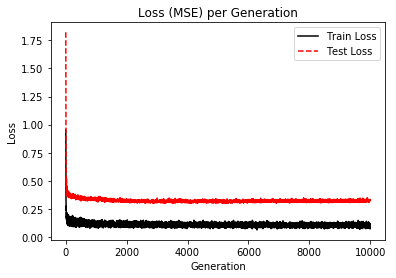

In [23]:
%matplotlib inline
# Plot loss (MSE) over time
plt.plot(train_loss, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.legend(loc='upper right')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

### Tensorboard Graph


What follows is the graph we have executed and all data about it. Note the "save" label and the several layers.


![graph_4](../images/graph_4.png)


### Saving a Tensorflow model

So, now we have our model saved.

Tensorflow model has four main files:
* a) Meta graph:
This is a protocol buffer which saves the complete Tensorflow graph; i.e. all variables, operations, collections etc. This file has .ckpt.meta extension.


* b) y c) Checkpoint files:
It is a binary file which contains all the values of the weights, biases, gradients and all the other variables saved. Tensorflow has changed from version 0.11. Instead of a single .ckpt file, we have now two files: .ckpt.index and .ckpt.data file that contains our training variables. 


* d) Along with this, Tensorflow also has a file named checkpoint which simply keeps a record of latest checkpoint files saved.



### Retrain the model


We can retrain the model as many times as we want to.

In [14]:
# Running a new session
print("Starting 2nd session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Restore model weights from previously saved model
    saver.restore(sess, model_path)
    print("Model restored from file: %s" % model_path)

    # Resume training
    for epoch in range(epochs):
        rand_index = np.random.choice(len(X_train), size=batch_size)
        X_rand = X_train[rand_index]
        y_rand = np.transpose([y_train[rand_index]])
        sess.run(optimizer, feed_dict={X: X_rand, y: y_rand})

        train_temp_loss = sess.run(loss, feed_dict={X: X_rand, y: y_rand})
        train_loss.append(np.sqrt(train_temp_loss))
    
        test_temp_loss = sess.run(loss, feed_dict={X: X_test, y: np.transpose([y_test])})
        test_loss.append(np.sqrt(test_temp_loss))
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "Lost=", \
                "{:.9f}".format(train_temp_loss))

    # Close writer
    writer.flush()
    writer.close()
    
    # Save model weights to disk
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)
    print("Second Optimization Finished!")


Starting 2nd session...
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Model restored from file: /tmp/model.ckpt
Epoch: 0050 Lost= 0.008463752
Epoch: 0100 Lost= 0.008815072
Epoch: 0150 Lost= 0.007444128
Epoch: 0200 Lost= 0.012498009
Epoch: 0250 Lost= 0.015526781
Epoch: 0300 Lost= 0.012171890
Epoch: 0350 Lost= 0.014126011
Epoch: 0400 Lost= 0.011582861
Epoch: 0450 Lost= 0.009279514
Epoch: 0500 Lost= 0.009013028
Epoch: 0550 Lost= 0.011625799
Epoch: 0600 Lost= 0.013471980
Epoch: 0650 Lost= 0.013085285
Epoch: 0700 Lost= 0.009605739
Epoch: 0750 Lost= 0.012162115
Epoch: 0800 Lost= 0.010167326
Epoch: 0850 Lost= 0.011518762
Epoch: 0900 Lost= 0.011800569
Epoch: 0950 Lost= 0.014925851
Epoch: 1000 Lost= 0.012793327
Epoch: 1050 Lost= 0.014287475
Epoch: 1100 Lost= 0.011415527
Epoch: 1150 Lost= 0.009499159
Epoch: 1200 Lost= 0.007076838
Epoch: 1250 Lost= 0.013134346
Epoch: 1300 Lost= 0.018337401
Epoch: 1350 Lost= 0.007836805
Epoch: 1400 Lost= 0.008267768
Epoch: 1450 Lost= 0.011545504
Epoch:

Epoch: 13400 Lost= 0.011293527
Epoch: 13450 Lost= 0.009493587
Epoch: 13500 Lost= 0.010870277
Epoch: 13550 Lost= 0.008922459
Epoch: 13600 Lost= 0.010322538
Epoch: 13650 Lost= 0.011845035
Epoch: 13700 Lost= 0.010104549
Epoch: 13750 Lost= 0.014247353
Epoch: 13800 Lost= 0.007739644
Epoch: 13850 Lost= 0.011274887
Epoch: 13900 Lost= 0.013678232
Epoch: 13950 Lost= 0.008041820
Epoch: 14000 Lost= 0.011556289
Epoch: 14050 Lost= 0.008686322
Epoch: 14100 Lost= 0.014746062
Epoch: 14150 Lost= 0.017041760
Epoch: 14200 Lost= 0.011626768
Epoch: 14250 Lost= 0.010382213
Epoch: 14300 Lost= 0.014497395
Epoch: 14350 Lost= 0.012169966
Epoch: 14400 Lost= 0.012364008
Epoch: 14450 Lost= 0.015698167
Epoch: 14500 Lost= 0.010881615
Epoch: 14550 Lost= 0.009091883
Epoch: 14600 Lost= 0.013474770
Epoch: 14650 Lost= 0.020503575
Epoch: 14700 Lost= 0.012836779
Epoch: 14750 Lost= 0.010574948
Epoch: 14800 Lost= 0.008672462
Epoch: 14850 Lost= 0.012719627
Epoch: 14900 Lost= 0.010736948
Epoch: 14950 Lost= 0.013090171
Epoch: 1

Epoch: 26700 Lost= 0.016164526
Epoch: 26750 Lost= 0.009434738
Epoch: 26800 Lost= 0.016138228
Epoch: 26850 Lost= 0.014105581
Epoch: 26900 Lost= 0.013943339
Epoch: 26950 Lost= 0.010524426
Epoch: 27000 Lost= 0.010945730
Epoch: 27050 Lost= 0.011162297
Epoch: 27100 Lost= 0.007755888
Epoch: 27150 Lost= 0.009518484
Epoch: 27200 Lost= 0.012039457
Epoch: 27250 Lost= 0.008134902
Epoch: 27300 Lost= 0.011165040
Epoch: 27350 Lost= 0.014721883
Epoch: 27400 Lost= 0.009012455
Epoch: 27450 Lost= 0.012551072
Epoch: 27500 Lost= 0.015252518
Epoch: 27550 Lost= 0.008795706
Epoch: 27600 Lost= 0.010518597
Epoch: 27650 Lost= 0.008739428
Epoch: 27700 Lost= 0.012034351
Epoch: 27750 Lost= 0.012025622
Epoch: 27800 Lost= 0.014928434
Epoch: 27850 Lost= 0.008774246
Epoch: 27900 Lost= 0.014420661
Epoch: 27950 Lost= 0.012363607
Epoch: 28000 Lost= 0.014496485
Epoch: 28050 Lost= 0.011301385
Epoch: 28100 Lost= 0.015959341
Epoch: 28150 Lost= 0.009081382
Epoch: 28200 Lost= 0.012519726
Epoch: 28250 Lost= 0.011324278
Epoch: 2

Epoch: 40000 Lost= 0.014414583
Epoch: 40050 Lost= 0.009851740
Epoch: 40100 Lost= 0.010153515
Epoch: 40150 Lost= 0.011280446
Epoch: 40200 Lost= 0.014669822
Epoch: 40250 Lost= 0.012289293
Epoch: 40300 Lost= 0.012809146
Epoch: 40350 Lost= 0.011316139
Epoch: 40400 Lost= 0.016626976
Epoch: 40450 Lost= 0.015164121
Epoch: 40500 Lost= 0.012281760
Epoch: 40550 Lost= 0.009220175
Epoch: 40600 Lost= 0.011773362
Epoch: 40650 Lost= 0.013620131
Epoch: 40700 Lost= 0.010681231
Epoch: 40750 Lost= 0.015292041
Epoch: 40800 Lost= 0.007681482
Epoch: 40850 Lost= 0.011209038
Epoch: 40900 Lost= 0.011626724
Epoch: 40950 Lost= 0.010695759
Epoch: 41000 Lost= 0.009442117
Epoch: 41050 Lost= 0.008215989
Epoch: 41100 Lost= 0.006356594
Epoch: 41150 Lost= 0.014944180
Epoch: 41200 Lost= 0.012484461
Epoch: 41250 Lost= 0.010139145
Epoch: 41300 Lost= 0.012141574
Epoch: 41350 Lost= 0.010919007
Epoch: 41400 Lost= 0.010355663
Epoch: 41450 Lost= 0.013756918
Epoch: 41500 Lost= 0.011876950
Epoch: 41550 Lost= 0.008072730
Epoch: 4

## Predict

Finally, we can use the model to make some predictions.

In [24]:
# Running a new session for predictions
print("Starting prediction session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Restore model weights from previously saved model
    saver.restore(sess, model_path)
    print("Model restored from file: %s" % model_path)

    # We try to predict the petal width (cm) of three samples
    feed_dict = {X: [[5.1, 3.5, 1.4],
                     [4.8, 3.0, 1.4],
                     [6.3, 3.4, 5.6]]
                }
    prediction = sess.run(y_hat, feed_dict)
    print(prediction) # True value 0.2, 0.1, 2.4


Starting prediction session...
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Model restored from file: /tmp/model.ckpt
[[0.23460037]
 [0.19889006]
 [2.0588052 ]]


OK, better results, but still not very good results. We could try to improve them with a deeper network (more layers) or retouching the net parameters and number of neurons. That is another story.